
# **生成对抗网络**

本实践使用生成对抗网络GAN来生成图片，使用的数据集是Mnist数据集，可以达到以假乱真的目的。

## 注意

1. 本项目代码需要使用GPU环境来运行:

<img src="https://ai-studio-static-online.cdn.bcebos.com/767f625548714f03b105b6ccb3aa78df9080e38d329e445380f505ddec6c7042" width="40%" height="40%">

<br>

<br>

并且检查相关参数设置, 例如use_gpu, fluid.CUDAPlace(0)等处是否设置正确. 

2. 每次成功运行一遍后, 需要重新启动代码执行器. 清除执行过程中累计的中间变量, 才能保证下一次的正确运行. 否则可能会影响预测结果. 

![](https://ai-studio-static-online.cdn.bcebos.com/829fb774a217400c9f2faa870803cc16978dc8e956e14601bc39aaab3d99db71)

首先导入必要的包。

In [1]:
import numpy as np
import paddle
import paddle.fluid as fluid
import matplotlib.pyplot as plt

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


# **Step1.数据准备**

In [2]:
# 噪声维度

z_dim = 100

# 读取真实图片的数据集，这里去除了数据集中的label数据，因为label在这里使用不上，这里不考虑标签分类问题。

def mnist_reader(reader):
    def r():
        for img, label in reader():
            yield img.reshape(1, 28, 28)
    return r

    

# 噪声生成，通过由噪声来生成假的图片数据输入。

def z_reader():
    while True:
        yield np.random.normal(0.0, 1.0, (z_dim, 1, 1)).astype('float32')


# 生成真实图片reader

mnist_generator = paddle.batch(
    paddle.reader.shuffle(mnist_reader(paddle.dataset.mnist.train()), 30000), batch_size=256)

# 生成假图片的reader

z_generator = paddle.batch(z_reader, batch_size=128)

# **Step2.网络配置**

生成对抗网络（GAN，Generative Adversarial Networks）的基本原理很简单：假设有两个网络，生成网络G和判别网络D。

**生成网络G**接受一个随机的噪声z并生成图片，记为G（z）；

**判别网络D**的作用是判别一张图片x是否真实，对于输入x，D(x)是x为真实图片的概率。判别器的作用是训练真实的数据集，然后使用训练真实数据集模型去判别生成器生成的假图片。这一过程可以理解判别器为一个二分类问题，判别器在训练真实数据集时，尽量让其输出概率为1，而训练生成器生成的假图片输出概率为0。这样不断给生成器压力，让其生成的图片尽量逼近真实图片，以至于真实到连判别器也无法判断这是真实图像还是假图片。

在训练过程中， 生成器努力让生成的图片更加真实从而使得判别器无法辨别图像的真假，而D的目标就是尽量把分辨出真实图片和生成网络G产出的图片，这个过程就类似于二人博弈，G和D构成了一个动态的“博弈过程”。

随着时间的推移，生成器和判别器在不断地进行对抗，最终两个网络达到一个动态平衡：生成器生成的图像G(z)接近于真实图像分布，而判别器识别不出真假图像，即D（G(z)）=0.5。最后，我们就可以得到一个生成网络G，用来生成图片。

![](https://ai-studio-static-online.cdn.bcebos.com/529965e419104bb2b850f04c07c86e4c3493e8aca46b4990be1c2df98b116a4b)

**生成网络G**接受一个随机的噪声z并生成图片，记为G（z）；

主要由两组全连接和BN层、两组转置卷积运算组成，其中最后一层的卷积层的卷积核数量是1，因为输出的图像是一个灰度图的手写字体图片。

In [3]:
# 定义生成器

def Generator(y, name="G"):
    with fluid.unique_name.guard(name + "/"):
        # 第一组全连接和BN层
        y = fluid.layers.fc(y, size=1024, act='relu')
        y = fluid.layers.batch_norm(y, act='relu')

        # 第二组全连接和BN层
        y = fluid.layers.fc(y, size=128 * 7 * 7)
        y = fluid.layers.batch_norm(y, act='relu')

        # 进行形状变换
        y = fluid.layers.reshape(y, shape=(-1, 128, 7, 7))

        # 第一组转置卷积运算
        y = fluid.layers.image_resize(y, scale=2)
        y = fluid.layers.conv2d(y, num_filters=64, filter_size=5, padding=2, act='relu')

        # 第二组转置卷积运算
        y = fluid.layers.image_resize(y, scale=2)
        y = fluid.layers.conv2d(y, num_filters=1, filter_size=5, padding=2, act='relu')

    return y

**判别器**的作用是训练真实的数据集，然后使用训练真实数据集模型去判别生成器生成的假图片。这一过程可以理解判别器为一个二分类问题，判别器在训练真实数据集时，尽量让其输出概率为1，而训练生成器生成的假图片输出概率为0。这样不断给生成器压力，让其生成的图片尽量逼近真实图片，以至于真实到连判别器也无法判断这是真实图像还是假图片。

以下判别器由三组卷积池化层和一个最后全连接层组成，全连接层的大小为1，输入一个二分类的结果。

In [4]:
# 判别器 Discriminator


def Discriminator(images, name="D"):
    # 一组卷积层和BN层
    def conv_bn(input, num_filters, filter_size):
        y = fluid.layers.conv2d(input=input,
                                num_filters=num_filters,
                                filter_size=filter_size,
                                stride=1,
                                bias_attr=False)

        # 激活函数为leaky ReLU

        y = fluid.layers.batch_norm(y, act="leaky_relu")
        return y


    with fluid.unique_name.guard(name + "/"):

        # 第一组卷积池化
        y = conv_bn(images, num_filters=64, filter_size=3)
        y = fluid.layers.pool2d(y, pool_size=2, pool_stride=2)

        # 第二组卷积池化
        y = conv_bn(y, num_filters=128, filter_size=3)
        y = fluid.layers.pool2d(y, pool_size=2, pool_stride=2)

        
        # 全连接输出层
        y = fluid.layers.fc(input=y, size=1024)
        y = fluid.layers.batch_norm(input=y, act='leaky_relu')
        y = fluid.layers.fc(y, size=1)

    return y

定义四个Program，其中使用三个Program分别进行训练生成器生成图片、训练判别器识别真实图片、训练判别器识别生成器生成的假图片，还要一个Program是用于初始化参数的。噪声的作用是初始化生成图片。

In [5]:
# 创建一个程序，功能：判别器D识别生成器G生成的假图片
train_d_fake = fluid.Program()

# 创建一个程序，功能：判别器D识别真实图片
train_d_real = fluid.Program()

# 创建一个程序，功能：生成器G生成符合判别器D的程序
train_g = fluid.Program()

#创建一个程序，功能：共同的一个初始化的程序
startup = fluid.Program()

获取Program中的独立参数，因为我们同时训练3个Program，其中训练生成器或训练判别器时，它们参数的更新不应该互相影响。就是训练判别器识别真实图片时，在更新判别器模型参数时，不要更新生成器模型的参数，同理更新生成器模型参数时，不要更新判别器的模型参数。

In [6]:
# 从Program获取prefix开头的参数名字

def get_params(program, prefix):
    all_params = program.global_block().all_parameters()
    return [t.name for t in all_params if t.name.startswith(prefix)]


定义一个判别器识别真实图片的程序，这里判别器传入的数据是真实的图片数据。这里使用的损失函数是fluid.layers.sigmoid_cross_entropy_with_logits()，这个损失函数是求它们在任务上的错误率，他们的类别是互不排斥的。所以无论真实图片的标签是什么，都不会影响模型识别为真实图片。这里更新的也只有判别器模型的参数，使用的优化方法是Adam。

In [7]:
paddle.enable_static()

# 训练判别器D识别真实图片
with fluid.program_guard(train_d_real, startup):
    # 创建读取真实数据集图片的data，并且label为1
    real_image = fluid.layers.data('image', shape=[1, 28, 28])
    ones = fluid.layers.fill_constant_batch_size_like(real_image, shape=[-1, 1], dtype='float32', value=1)

    # 判别器D判断真实图片的概率
    p_real = Discriminator(real_image)

    # 获取损失函数
    real_cost = fluid.layers.sigmoid_cross_entropy_with_logits(p_real, ones)
    real_avg_cost = fluid.layers.mean(real_cost)


    # 获取判别器D的参数
    d_params = get_params(train_d_real, "D")


    # 创建优化方法
    optimizer = fluid.optimizer.AdamOptimizer(learning_rate=1e-4)
    optimizer.minimize(real_avg_cost, parameter_list=d_params)

这里定义一个判别器识别生成器生成的图片的程序，这里是使用噪声的维度进行输入。这里判别器识别的是生成器生成的图片，这里使用的损失函数同样是fluid.layers.sigmoid_cross_entropy_with_logits()。这里更新的参数还是判别器模型的参数，也是使用Adam优化方法。

In [8]:
# 训练判别器D识别生成器G生成的图片为假图片

with fluid.program_guard(train_d_fake, startup):

    # 利用创建假的图片data，并且label为0
    z = fluid.layers.data(name='z', shape=[z_dim, 1, 1])
    zeros = fluid.layers.fill_constant_batch_size_like(z, shape=[-1, 1], dtype='float32', value=0)#创建一个张量，用value中提供的常量来初始化张量


    # 判别器D判断假图片的概率
    p_fake = Discriminator(Generator(z))


    # 获取损失函数
    fake_cost = fluid.layers.sigmoid_cross_entropy_with_logits(p_fake, zeros)
    fake_avg_cost = fluid.layers.mean(fake_cost)


    # 获取判别器D的参数
    d_params = get_params(train_d_fake, "D")


    # 创建优化方法
    optimizer = fluid.optimizer.AdamOptimizer(learning_rate=1e-4)
    optimizer.minimize(fake_avg_cost, parameter_list=d_params)

最后定义一个训练生成器生成图片的模型，这里也克隆一个预测程序，用于之后在训练的时候输出预测的图片。损失函数和优化方法都一样，但是要更新的参数是生成器的模型参。

In [9]:
# 训练生成器G生成符合判别器D标准的假图片

with fluid.program_guard(train_g, startup):
    # 噪声生成图片为真实图片的概率，Label为1
    z = fluid.layers.data(name='z', shape=[z_dim, 1, 1])
    ones = fluid.layers.fill_constant_batch_size_like(z, shape=[-1, 1], dtype='float32', value=1)


    # 生成图片
    fake = Generator(z)

    # 克隆预测程序
    infer_program = train_g.clone(for_test=True)

    # 生成符合判别器的假图片
    p = Discriminator(fake)

    # 获取损失函数
    g_cost = fluid.layers.sigmoid_cross_entropy_with_logits(p, ones)
    g_avg_cost = fluid.layers.mean(g_cost)

    # 获取G的参数
    g_params = get_params(train_g, "G")

    # 只训练G
    optimizer = fluid.optimizer.AdamOptimizer(learning_rate=1e-4)
    optimizer.minimize(g_avg_cost, parameter_list=g_params)

In [10]:

# 显示图片，构建一个8*8的图片阵列，把预测的图片打印出来。

def show_image_grid(images, pass_id=None):
    fig = plt.figure(figsize=(5, 5))
    fig.suptitle("Pass {}".format(pass_id))
    gs = plt.GridSpec(8, 8)
    gs.update(wspace=0.05, hspace=0.05)

    for i, image in enumerate(images[:64]):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(image[0], cmap='Greys_r')
        
    plt.show()

# **Step3.网络训练&Step4.网络预测**

In [11]:
# 创建解析器

# 定义使用CPU还是GPU，使用CPU时use_cuda = False,使用GPU时use_cuda = True
use_cuda = True
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)

# 初始化参数
exe.run(startup)

W0112 12:53:31.219019   613 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.2
W0112 12:53:31.221892   613 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.


[]

获取测试需要的噪声数据，使用这些数据进行预测，获取预测的图片。

In [12]:
# 测试噪声数据
test_z = np.array(next(z_generator()))


开始训练，这里同时训练了3个程序，分别是训练判别器D识别生成器G生成的假图片、训练判别器D识别真实图片、训练生成器G生成符合判别器D标准的假图片。通过不断更新判别器的参数，使得判别器的识别能力越来越强。不断更新生成器的参数，使得生成器生成的图像越来越逼近真实图像。在每一轮训练结束后，进行一次预测，输入生成器生成的图片并显示出来。

Pass：0，fake_avg_cost：0.428197, real_avg_cost：0.237047, g_avg_cost：1.099093


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since Num

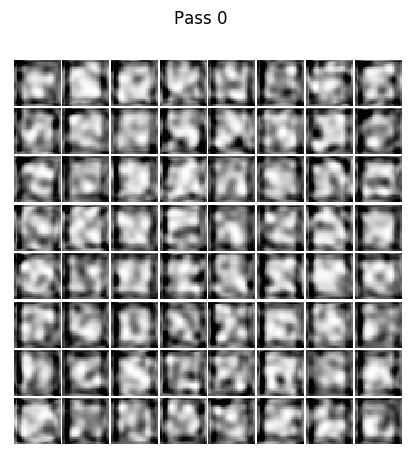

Pass：1，fake_avg_cost：0.298092, real_avg_cost：0.255103, g_avg_cost：1.485118


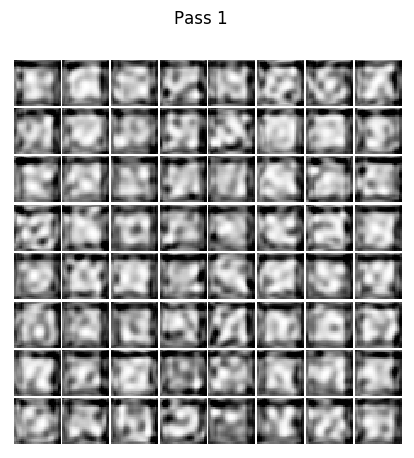

Pass：2，fake_avg_cost：0.353677, real_avg_cost：0.244376, g_avg_cost：1.446985


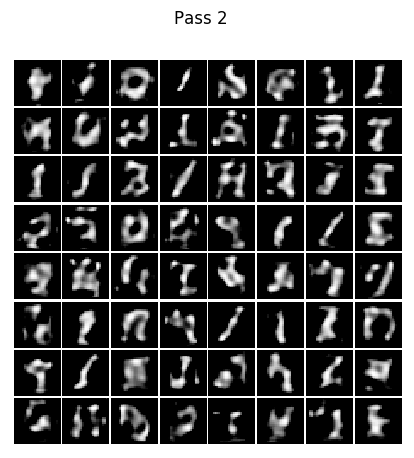

Pass：3，fake_avg_cost：0.407289, real_avg_cost：0.249391, g_avg_cost：1.252214


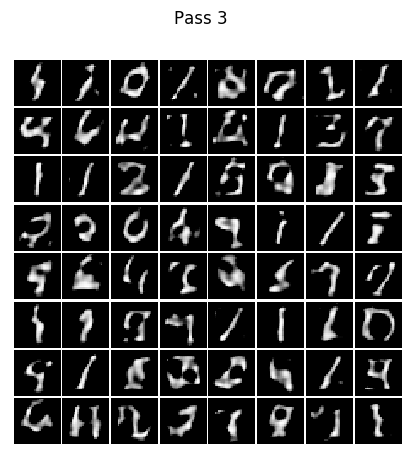

Pass：4，fake_avg_cost：0.433800, real_avg_cost：0.257574, g_avg_cost：1.171235


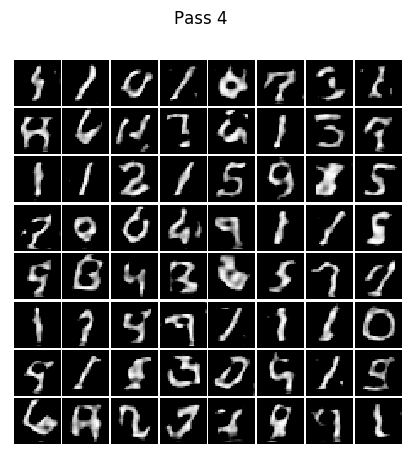

Pass：5，fake_avg_cost：0.436074, real_avg_cost：0.299777, g_avg_cost：1.095925


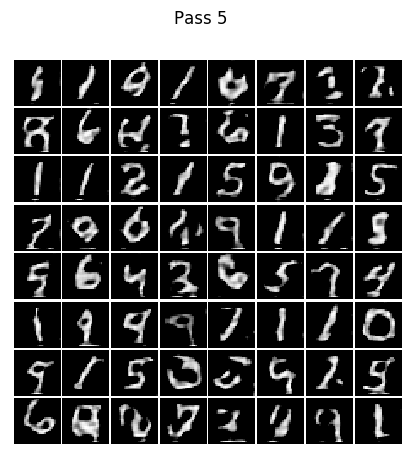

Pass：6，fake_avg_cost：0.480372, real_avg_cost：0.274791, g_avg_cost：1.087979


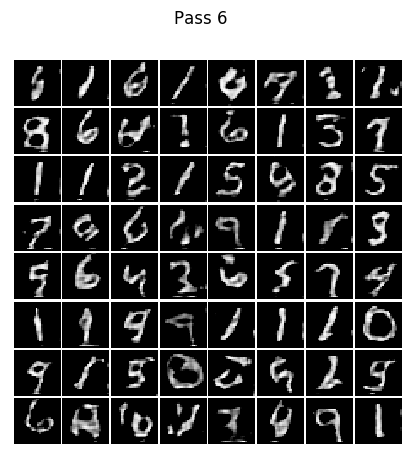

Pass：7，fake_avg_cost：0.449666, real_avg_cost：0.294207, g_avg_cost：1.120812


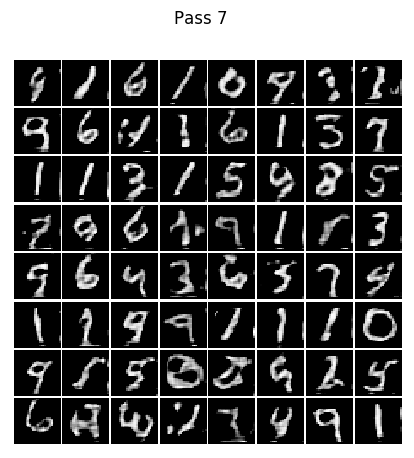

Pass：8，fake_avg_cost：0.439698, real_avg_cost：0.308882, g_avg_cost：1.129354


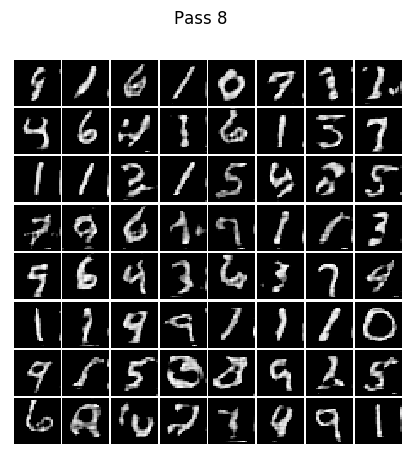

Pass：9，fake_avg_cost：0.439250, real_avg_cost：0.298142, g_avg_cost：1.148473


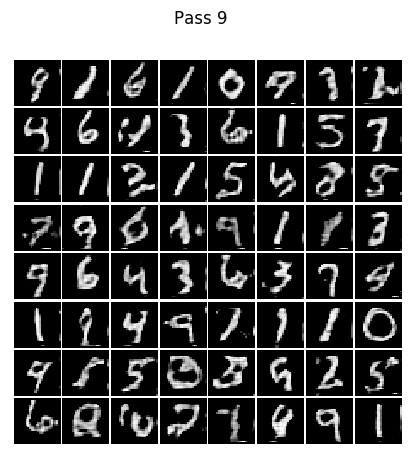

Pass：10，fake_avg_cost：0.422840, real_avg_cost：0.306195, g_avg_cost：1.105278


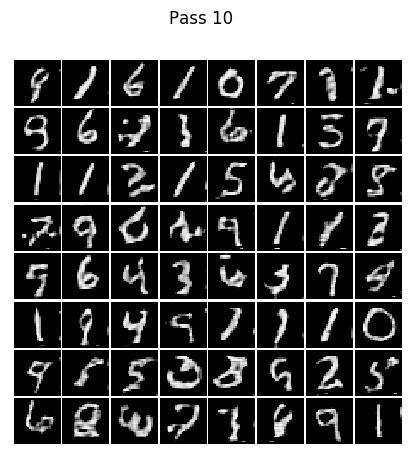

Pass：11，fake_avg_cost：0.452819, real_avg_cost：0.282295, g_avg_cost：1.150903


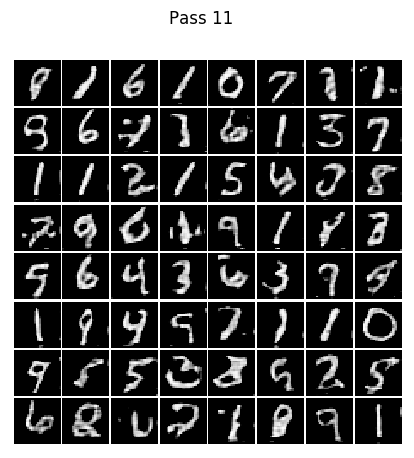

Pass：12，fake_avg_cost：0.426727, real_avg_cost：0.332696, g_avg_cost：1.085862


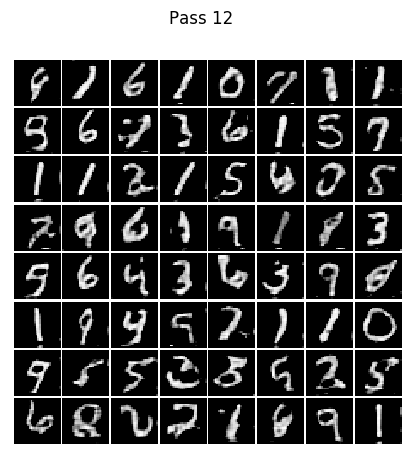

Pass：13，fake_avg_cost：0.484396, real_avg_cost：0.299435, g_avg_cost：1.133704


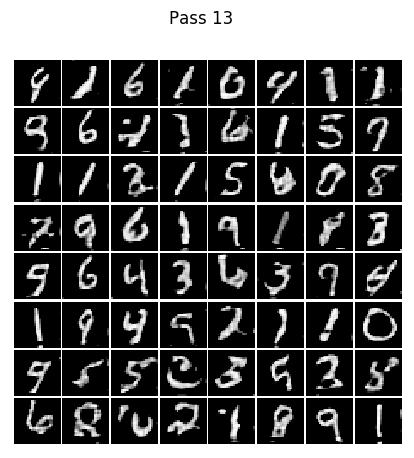

Pass：14，fake_avg_cost：0.463203, real_avg_cost：0.335578, g_avg_cost：1.156781


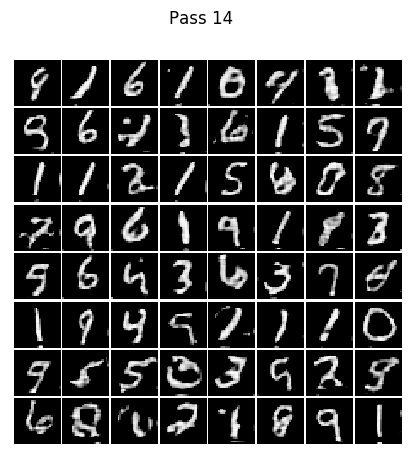

Pass：15，fake_avg_cost：0.491691, real_avg_cost：0.296264, g_avg_cost：1.208160


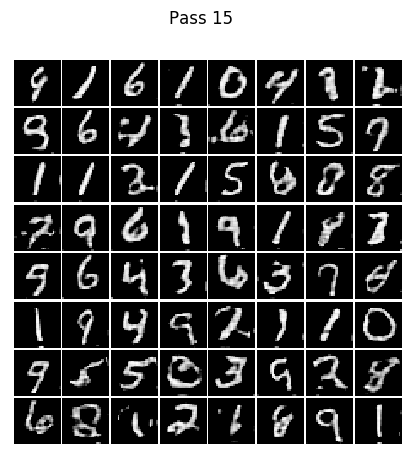

Pass：16，fake_avg_cost：0.438807, real_avg_cost：0.326431, g_avg_cost：1.087037


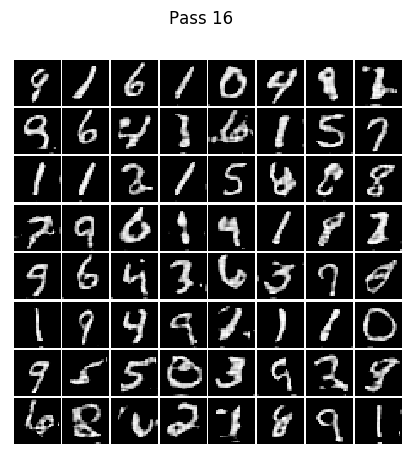

Pass：17，fake_avg_cost：0.477465, real_avg_cost：0.319485, g_avg_cost：1.151349


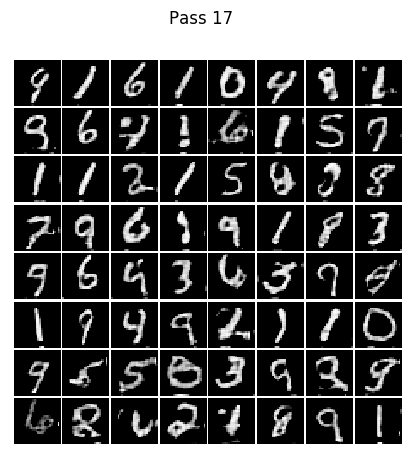

Pass：18，fake_avg_cost：0.453414, real_avg_cost：0.244173, g_avg_cost：1.096287


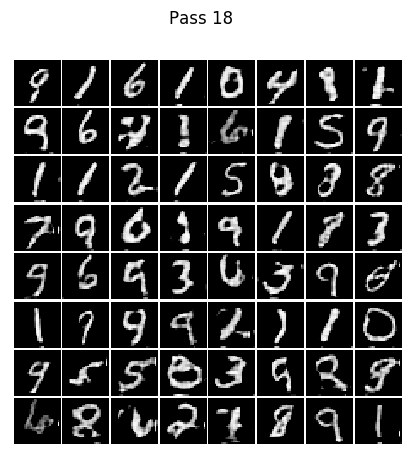

Pass：19，fake_avg_cost：0.456237, real_avg_cost：0.291168, g_avg_cost：1.104428


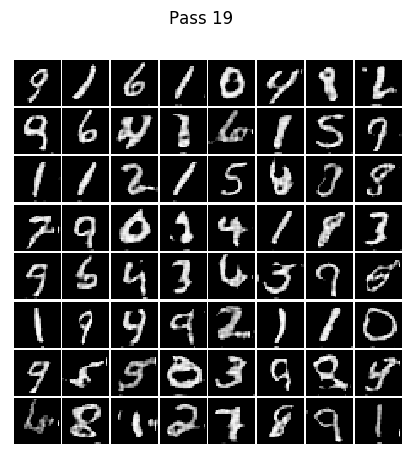

Pass：20，fake_avg_cost：0.434648, real_avg_cost：0.384970, g_avg_cost：1.055841


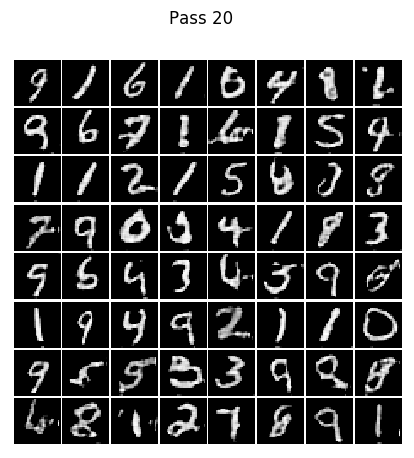

Pass：21，fake_avg_cost：0.443251, real_avg_cost：0.341824, g_avg_cost：1.125312


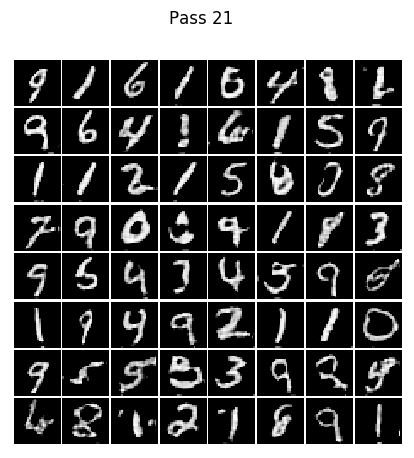

Pass：22，fake_avg_cost：0.439787, real_avg_cost：0.311574, g_avg_cost：1.108802


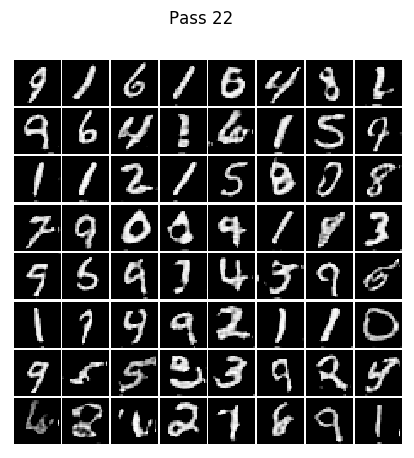

Pass：23，fake_avg_cost：0.409065, real_avg_cost：0.261425, g_avg_cost：1.120930


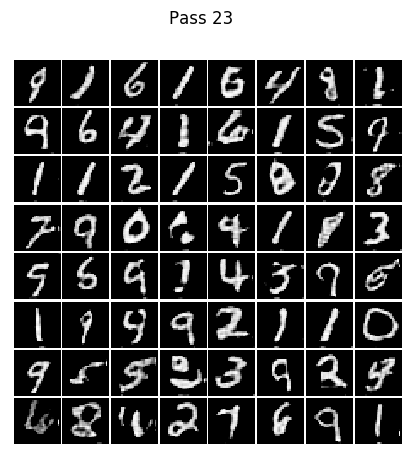

Pass：24，fake_avg_cost：0.428239, real_avg_cost：0.322012, g_avg_cost：1.093306


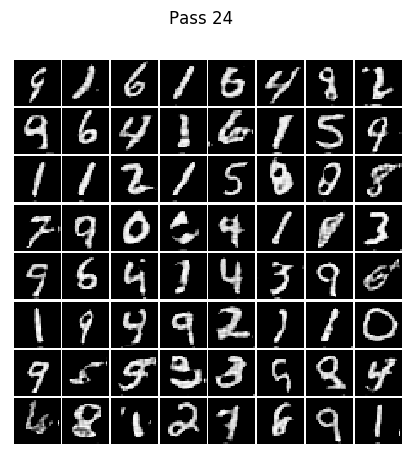

Pass：25，fake_avg_cost：0.461352, real_avg_cost：0.260819, g_avg_cost：1.158899


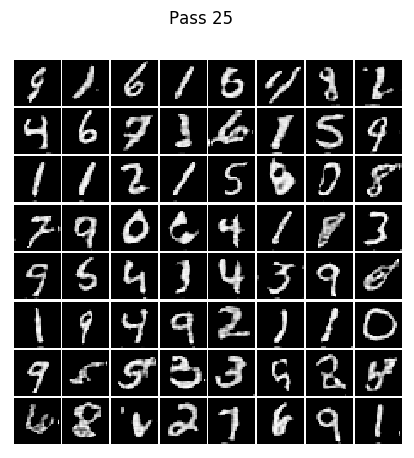

Pass：26，fake_avg_cost：0.434262, real_avg_cost：0.296789, g_avg_cost：1.175269


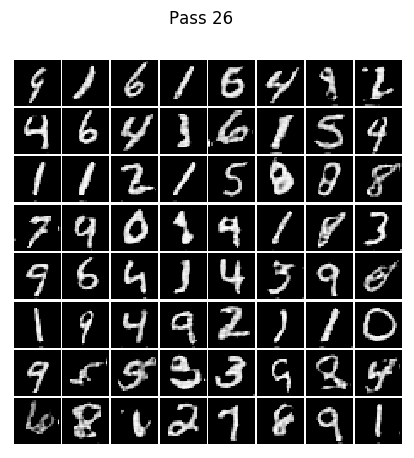

Pass：27，fake_avg_cost：0.495985, real_avg_cost：0.309497, g_avg_cost：1.120316


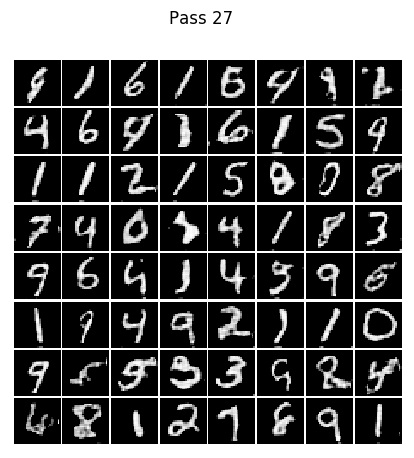

Pass：28，fake_avg_cost：0.478700, real_avg_cost：0.327512, g_avg_cost：1.057660


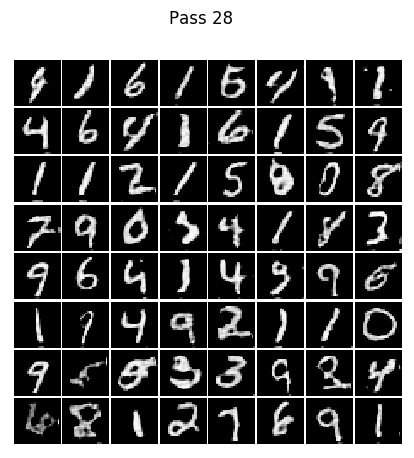

Pass：29，fake_avg_cost：0.420361, real_avg_cost：0.342114, g_avg_cost：1.116903


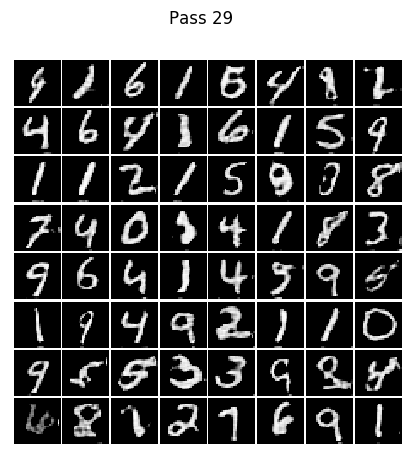

In [13]:
# 开始训练
## 自行填写训练轮次的数值，并完成训练。建议数值：>12。
EPOCHS = 30
for pass_id in range(EPOCHS):
    for i, real_image in enumerate(mnist_generator()):
        # 训练判别器D识别生成器G生成的假图片
        r_fake = exe.run(program=train_d_fake,
                         fetch_list=[fake_avg_cost],
                         feed={'z': np.array(next(z_generator()))})


        # 训练判别器D识别真实图片
        r_real = exe.run(program=train_d_real,
                         fetch_list=[real_avg_cost],
                         feed={'image': np.array(real_image)})


        # 训练生成器G生成符合判别器D标准的假图片

        r_g = exe.run(program=train_g,
                      fetch_list=[g_avg_cost],
                      feed={'z': np.array(next(z_generator()))})

    print("Pass：%d，fake_avg_cost：%f, real_avg_cost：%f, g_avg_cost：%f" % (pass_id, r_fake[0][0], r_real[0][0], r_g[0][0]))


    # 测试生成的图片

    r_i = exe.run(program=infer_program,
                  fetch_list=[fake],
                  feed={'z': test_z})


    # 显示生成的图片

    show_image_grid(r_i[0], pass_id)